In [19]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()

In [23]:
# Check the file path
file_path = "Resources/hawaii.sqlite"

if os.path.isfile(file_path):
    print("The file exists.")
else:
    print("The file does not exist or the file path is incorrect.")

The file exists.


In [24]:
# reflect an existing database into a new model
Base = automap_base()

In [25]:
# reflect the tables
Base.prepare(autoload_with=engine)

In [26]:
# View all of the classes that automap found
for table_name in Base.classes.keys():
    print(table_name)

measurement
station


In [9]:
# Save references to each table
stations = Base.classes.station
measurements = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
max_date = session.query(func.max(measurements.date)).scalar()

print(f"The most recent date in the data set is {max_date}.")

The most recent date in the data set is 2017-08-23.


In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data se
past_12 = pd.to_datetime(max_date) - pd.DateOffset(months=12)
past_12_str = past_12.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurements.date, measurements.prcp)\
                  .filter(measurements.date >= past_12_str)\
                  .filter(measurements.date <= max_date)\
                  .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(results, columns=['date', 'prcp'])
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_index()
precip_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


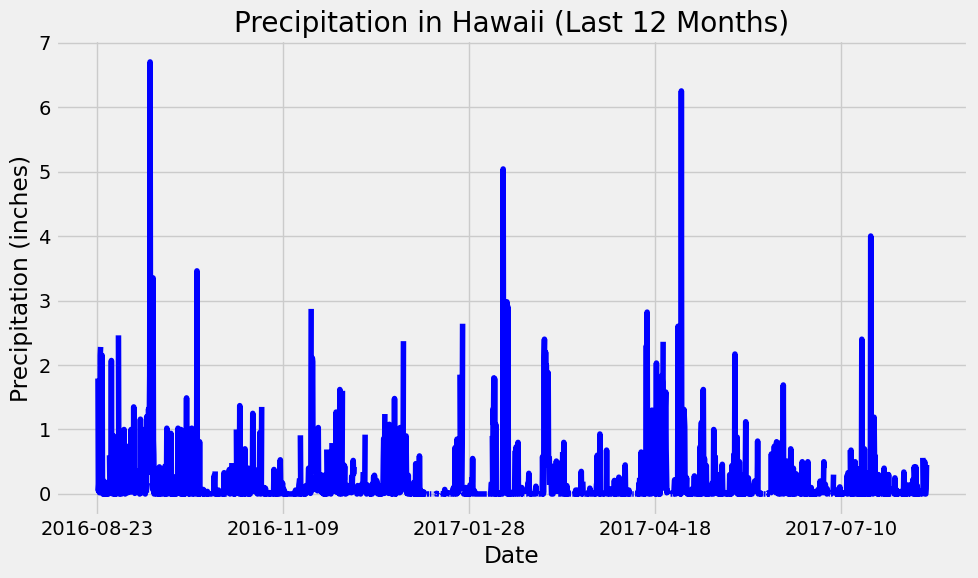

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10, 6))
precip_df.plot(ax=ax, y='prcp', color='blue', legend=False)
ax.set(title="Precipitation in Hawaii (Last 12 Months)", xlabel="Date", ylabel="Precipitation (inches)")
plt.tight_layout()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
stations_count = session.query(func.count(stations.station)).scalar()

# Print the total number of stations
print(f"Total number of stations: {stations_count}")

Total number of stations: 9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(measurements.station, func.count(measurements.station).label('activity_count')) \
                  .group_by(measurements.station) \
                  .order_by(func.count(measurements.station).desc()) \
                  .all()
# Print the results
for station in most_active_stations:
    print(f"Station: {station.station}, Activity Count: {station.activity_count}")

Station: USC00519281, Activity Count: 2772
Station: USC00519397, Activity Count: 2724
Station: USC00513117, Activity Count: 2709
Station: USC00519523, Activity Count: 2669
Station: USC00516128, Activity Count: 2612
Station: USC00514830, Activity Count: 2202
Station: USC00511918, Activity Count: 1979
Station: USC00517948, Activity Count: 1372
Station: USC00518838, Activity Count: 511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurements.tobs), 
       func.max(measurements.tobs), 
       func.avg(measurements.tobs)]

temps_USC00519281 = session.query(*sel).\
                    filter(measurements.station == 'USC00519281').\
                    all()

print(f"Lowest Temperature: {temps_USC00519281[0][0]} F")
print(f"Highest Temperature: {temps_USC00519281[0][1]} F")
print(f"Average Temperature: {temps_USC00519281[0][2]} F")

Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66378066378067 F


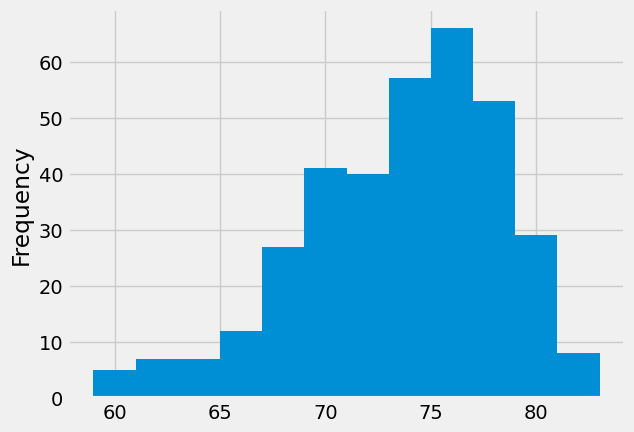

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
start_date = '2016-08-23'
end_date = '2017-08-23'

temp_results = session.query(measurements.tobs).\
                filter(measurements.station == 'USC00519281').\
                filter(measurements.date >= start_date).\
                filter(measurements.date <= end_date).all()

temp_df = pd.DataFrame(temp_results)

plt.hist(temp_df, bins=12)
plt.ylabel('Frequency')
plt.show()

# Close session

In [18]:
# Close Session
session.close()